In [50]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import os

from PlottingScripts import CV, Spline, Tune1, distVar

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [45]:
def distplot_wratio(nbins,myrange,vartest,stxcoord,legpos=0,ymax=-1):
    
    fig,ax = plt.subplots(figsize=(16,11))
    
    writepval=True
    fig.patch.set_alpha(1)
    
    var_run1 = df_data_run1_sel[vartest]
    var_run3 = df_data_run3_sel[vartest]
    
    vals_run1,binedges = np.histogram(var_run1,nbins,range=myrange,weights=weights_run1_sel)
    vals_run3,_ = np.histogram(var_run3,nbins,range=myrange,weights=weights_run3_sel)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    if ymax < 0: ymax = max(vals_run1.max(),vals_run3.max())*1.35
    
    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(.5,1.5)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Run3/Run1',fontsize=20)
    ax0.set_title('MCC9 Run3/Run1 Data',fontsize=30)

    ax0.errorbar(bincenters,vals_run1,fmt='o',yerr=np.sqrt(vals_run1/RUN1_POT*POT_SCALE_FACTOR),color='coral',capsize=8,label='Run1 Data (%i)'%vals_run1.sum())
    ax0.errorbar(bincenters,vals_run3,fmt='.',yerr=np.sqrt(vals_run3/RUN3_POT*POT_SCALE_FACTOR),color='rebeccapurple',capsize=5,label='Run3 Data (%i)'%vals_run3.sum())
    
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)
    
    # Ok. we're gonna do error differently!
    er_rat_dots = np.true_divide(np.sqrt(vals_run3/RUN3_POT*POT_SCALE_FACTOR),vals_run1,where=vals_run1!=0)
    er_rat_line = np.true_divide(np.sqrt(vals_run1/RUN1_POT*POT_SCALE_FACTOR),vals_run1,where=vals_run1!=0)
     
    chisq = np.true_divide(np.power(vals_run3-vals_run1,2),np.power(np.sqrt(vals_run1/RUN1_POT*POT_SCALE_FACTOR)+np.sqrt(vals_run3/RUN3_POT*POT_SCALE_FACTOR),2),where=vals_run1!=0).sum()
    ndof = np.count_nonzero(er_rat_dots)

    pval = 1 - stats.chi2.cdf(chisq,ndof)
    
    errboxes = []
    for i in range(len(bincenters)):
        rect = Rectangle((binedges[i],1.0-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes.append(rect)
    pc = PatchCollection(errboxes, facecolor='red', alpha=.3)
    ax1.add_collection(pc)
    ax1.errorbar(bincenters,np.true_divide(vals_run3,vals_run1),yerr=er_rat_dots,fmt='o',color='maroon',capsize=0)
    
    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0,label='Run1 Stat Error')
    legloc = ['upper left','lower left','lower right']
    ax1.legend(loc=legloc[legpos],fontsize=15,frameon=False)
    
    ax1.axhline(1,color='maroon',linestyle=':')
    ax0.annotate(r'$\sum$Run3/$\sum$Run1 = %.2f'%(vals_run3.sum()/float(vals_run1.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    if writepval:
        ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/%i dof$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))

    return fig,ax0


In [26]:
#wc tagger
RUN1_POT = 4.403e+19   #  run1
#RUN3_POT = 8.808e+18 # run3 (no beam quality cut)
RUN3_POT = 1.701e+20 #1.5e20

POT_SCALE_FACTOR = RUN1_POT
RUN1_SCALE = POT_SCALE_FACTOR / float(RUN1_POT)
RUN3_SCALE = POT_SCALE_FACTOR / float(RUN3_POT)

In [27]:
tag = 'May1'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'
bdtcut = 'BDTscore_1mu1p_cosmic > 0 and BDTscore_1mu1p_nu > 0'


cuts = orthogonalcut + ' and ' + precuts + ' and ' + bdtcut
df_data_run1_sel = pd.read_parquet('../data/pickles/data_run1_nodupes%s.parquet'%tag).query(cuts)
df_data_run3_sel = pd.read_parquet('../data/pickles/data_run3_filter_nodupes%s.parquet'%tag).query(cuts)

In [28]:
weights_run1_sel = np.ones(len(df_data_run1_sel))*RUN1_SCALE
weights_run3_sel = np.ones(len(df_data_run3_sel))*RUN3_SCALE

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


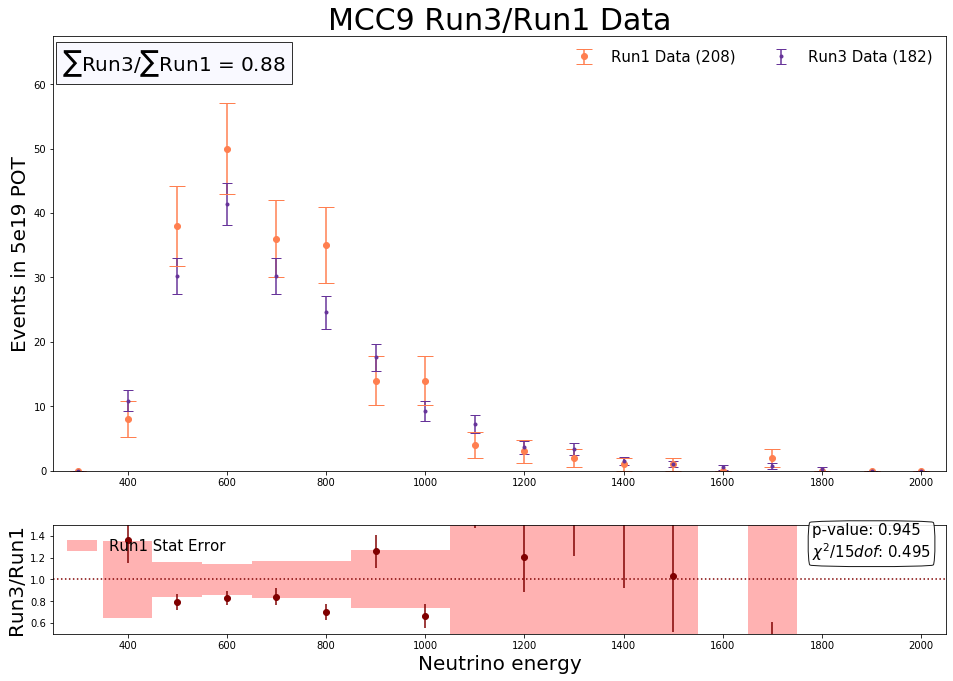

In [47]:
fig,ax0 = distplot_wratio(18,(250,2050),'Enu_1m1p','Neutrino energy')

In [48]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlist = []

varlist.append(distVar('Xreco',(15,241.25),'Reco Vertex X','../data/CovMatrices_Apr20/covar_postsel__x_reco.txt'))
varlist.append(distVar('Yreco',(-101.5,101.5),'Reco Vertex Y','../data/CovMatrices_Apr20/covar_postsel__y_reco.txt'))
varlist.append(distVar('Zreco',(15,1021.8),'Reco Vertex Z','../data/CovMatrices_Apr20/covar_postsel__z_reco.txt'))
varlist.append(distVar('Good3DReco',(0,1),'Good 3D Reco (tracker metric)'))
varlist.append(distVar('Eta',(0,.8),r'$\eta$','../data/CovMatrices_Apr20/covar_postsel__eta.txt'))
varlist.append(distVar('OpenAng',(.5,np.pi),'Opening Angle (rads)','../data/CovMatrices_Apr20/covar_postsel__openang_reco.txt'))
varlist.append(distVar('Thetas',(0,2*np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)','../data/CovMatrices_Apr20/covar_postsel__sum_thetas_reco.txt'))
varlist.append(distVar('Phis',(0,2*np.pi),r'Sum of Phis ($\phi_{p} + \phi_{\mu}$)  (rads)','../data/CovMatrices_Apr20/covar_postsel__sum_phis_reco.txt'))
varlist.append(distVar('ChargeNearTrunk',(0,800),'ADC Charge within 5cm of Reco Vertex','../data/CovMatrices_Apr20/covar_postsel__charge_near_trunk_reco.txt'))
varlist.append(distVar('CCQEEnergyShift_1m1p',(0,5),'Energy Shift (in MeV) to Maximize QE Consistency'))
varlist.append(distVar('Enu_1m1p',(200,2000),'Reconstructed Neutrino Energy (MeV)','../data/CovMatrices_Apr20/covar_postsel__nu_energy_reco.txt'))
varlist.append(distVar('PhiT_1m1p',(0,np.pi),r'$\phi_T$','../data/CovMatrices_Apr20/covar_postsel__phiT_reco.txt'))
varlist.append(distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$','../data/CovMatrices_Apr20/covar_postsel__alphaT_reco.txt'))
varlist.append(distVar('PT_1m1p',(0,850),r'$p_T$','../data/CovMatrices_Apr20/covar_postsel__pT_reco.txt'))
varlist.append(distVar('PTRat_1m1p',(0,1),r'$p_T/|p|$','../data/CovMatrices_Apr20/covar_postsel__pT_ratio_reco.txt'))
varlist.append(distVar('BjX_1m1p',(0,2),'Bjorken X','../data/CovMatrices_Apr20/covar_postsel__Bjx_reco.txt'))
varlist.append(distVar('BjY_1m1p',(0,1),'Bjorken Y','../data/CovMatrices_Apr20/covar_postsel__Bjy_reco.txt'))
varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
varlist.append(distVar('Sph_1m1p',(0,4000),'QE Consistency','../data/CovMatrices_Apr20/covar_postsel__sph_reco.txt'))
varlist.append(distVar('PzEnu_1m1p',(-1500,400),r'$p_z - E_\nu$ (MeV)'))
varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))
varlist.append(distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$','../data/CovMatrices_Apr20/covar_postsel__lepton_phi_reco.txt'))
varlist.append(distVar('Lepton_ThetaReco',(0,np.pi),r'Muon $\theta$','../data/CovMatrices_Apr20/covar_postsel__lepton_theta_reco.txt'))
varlist.append(distVar('Lepton_TrackLength',(5,200),'Muon Track Length (cm)','../data/CovMatrices_Apr20/covar_postsel__lepton_length_reco.txt'))
varlist.append(distVar('Muon_Edep',(20,600),'Reco Muon Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__lepton_KE_reco.txt'))
varlist.append(distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$','../data/CovMatrices_Apr20/covar_postsel__proton_phi_reco.txt'))
varlist.append(distVar('Proton_ThetaReco',(0,np.pi),r'Proton $\theta$','../data/CovMatrices_Apr20/covar_postsel__proton_theta_reco.txt'))
varlist.append(distVar('Proton_TrackLength',(5,150),'Proton Track Length','../data/CovMatrices_Apr20/covar_postsel__proton_length_reco.txt'))
varlist.append(distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__proton_KE_reco.txt'))

In [52]:
dumpbins = 18
dumphole = 'DataData_May7' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlist:
    fig,ax0 = distplot_wratio(dumpbins,dist.myrange,dist.myname,dist.mylabel)
    
    ax0.set_ylabel('Events in 5e19',fontsize=25)
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


Text(0.1, 0.1, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

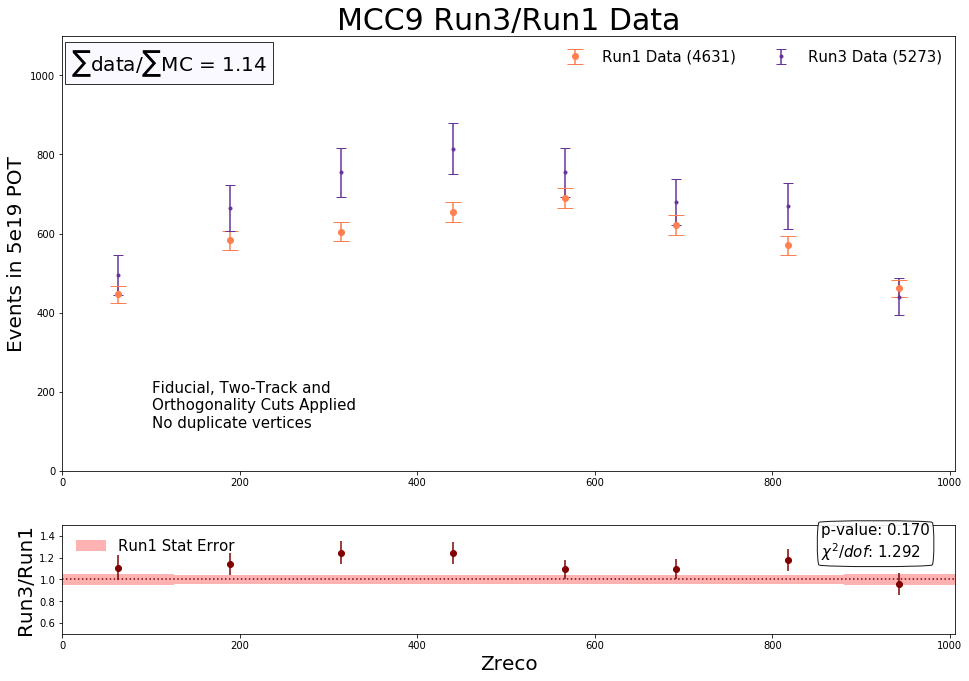

In [62]:
vartest = 'Zreco'
varname = 'Zreco'
myrange = (0,1006)
nbins = 8
yscale = 1.2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.1), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

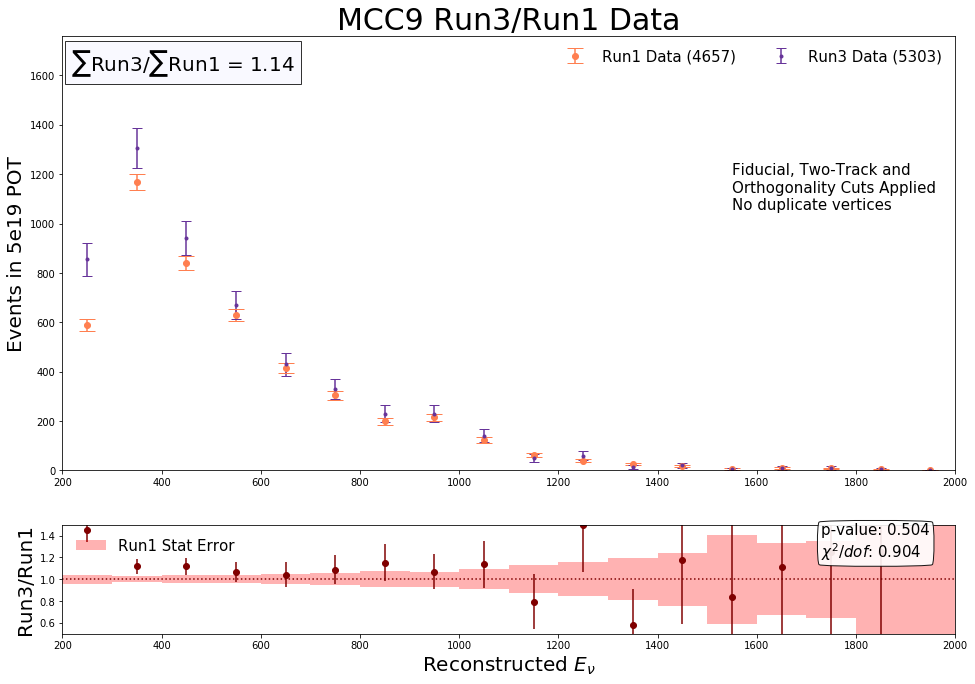

In [11]:
vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (200,2000)
nbins = 18
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

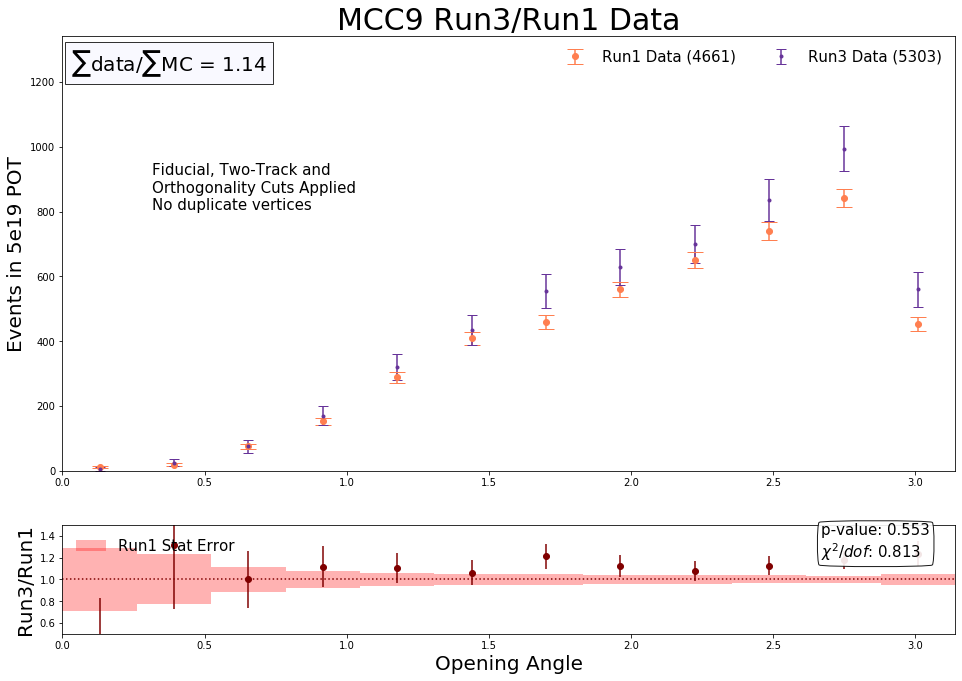

In [43]:
vartest = 'OpenAng'
varname = 'Opening Angle'
myrange = (0,np.pi)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

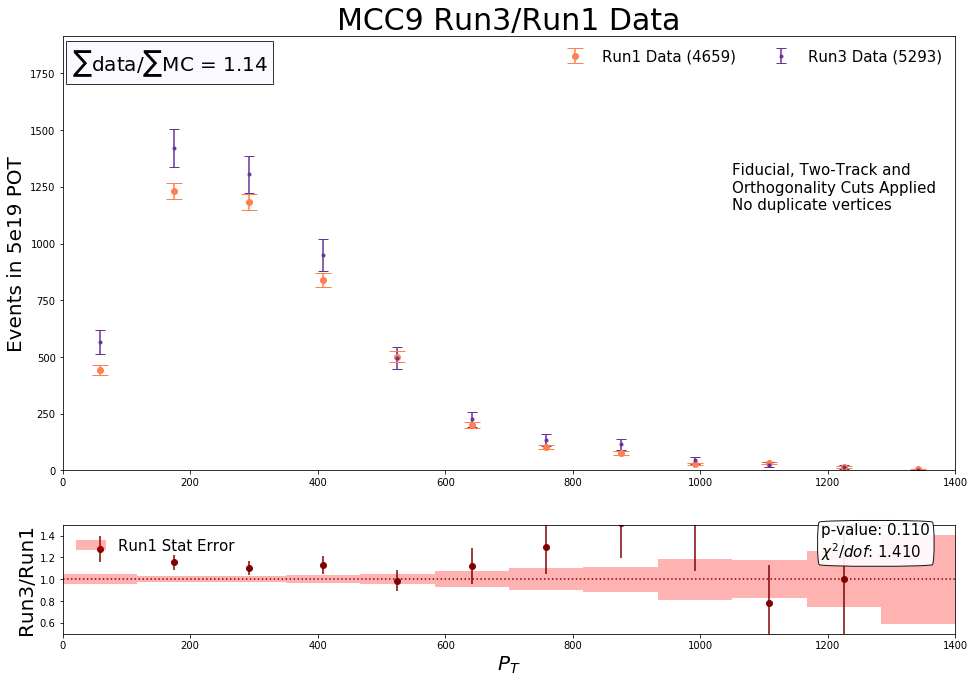

In [64]:
vartest = 'PT_1m1p'
varname = r'$P_T$'
myrange = (0,1400)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

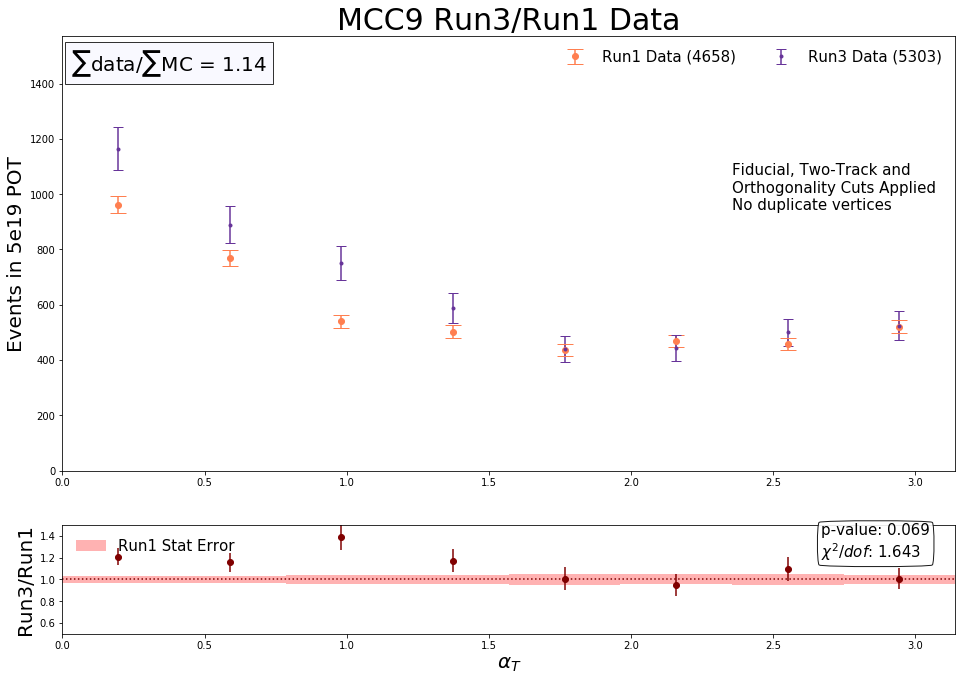

In [65]:
vartest = 'AlphaT_1m1p'
varname = r'$\alpha_T$'
myrange = (0,np.pi)
nbins = 8
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

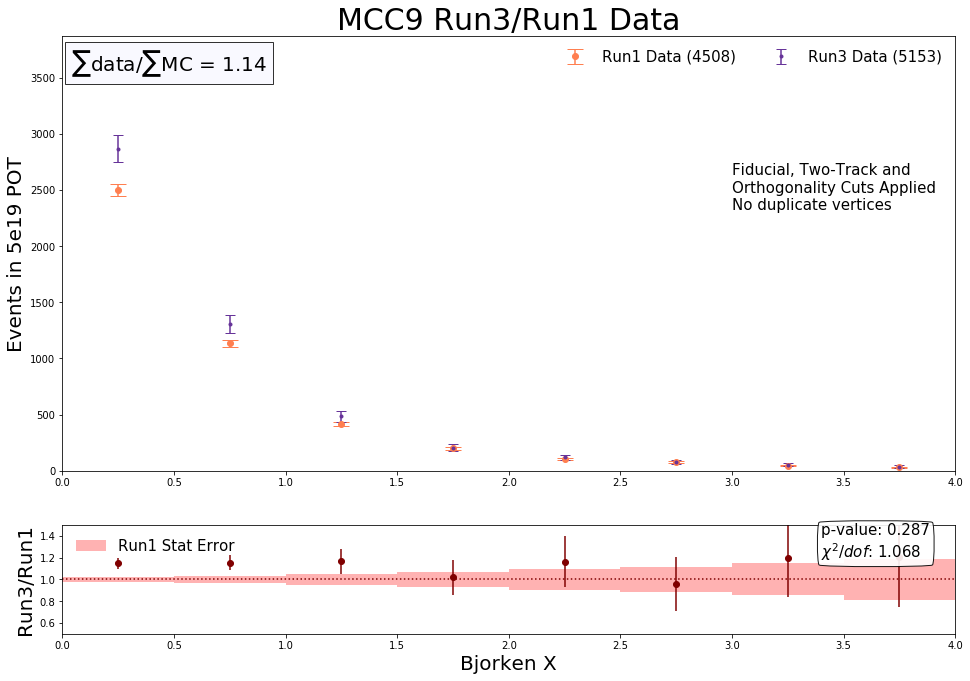

In [66]:
vartest = 'BjX_1m1p'
varname = r'Bjorken X'
myrange = (0,4)
nbins = 8
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

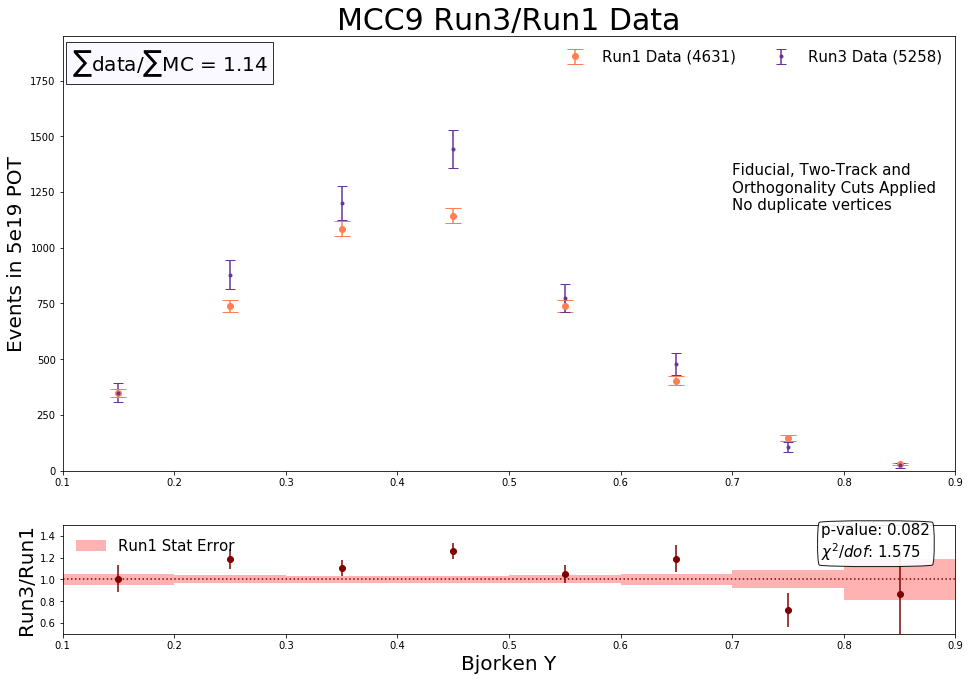

In [67]:
vartest = 'BjY_1m1p'
varname = r'Bjorken Y'
myrange = (.1,.9)
nbins = 8
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

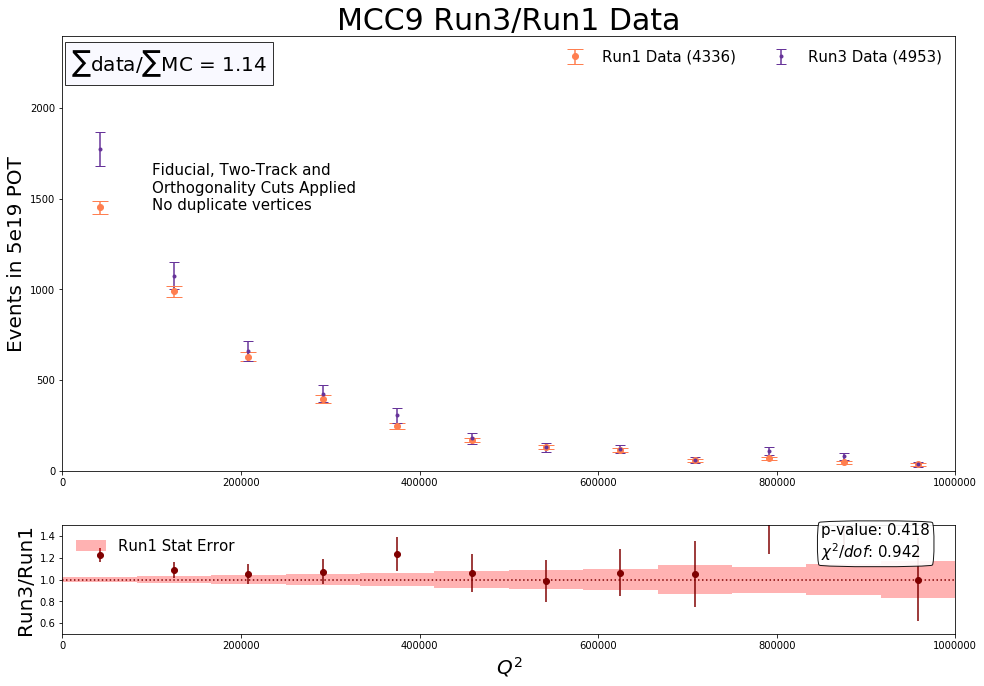

In [48]:
vartest = 'Q2_1m1p'
varname = r'$Q^2$'
myrange = (0,1e6)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.6), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

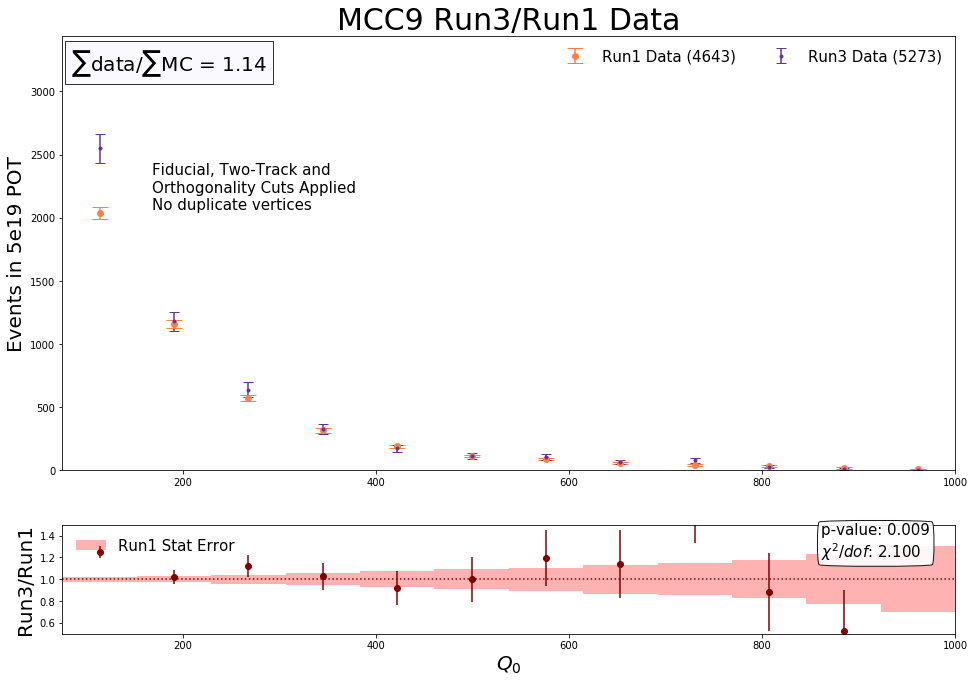

In [49]:
vartest = 'Q0_1m1p'
varname = r'$Q_0$'
myrange = (75,1e3)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

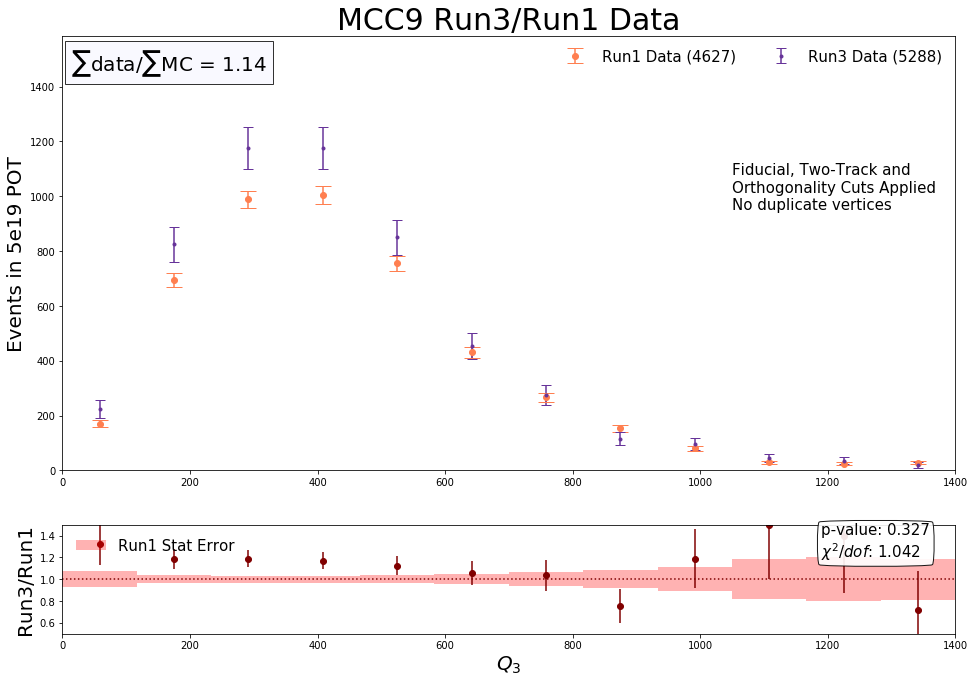

In [68]:
vartest = 'Q3_1m1p'
varname = r'$Q_3$'
myrange = (0,1.4e3)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.1, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

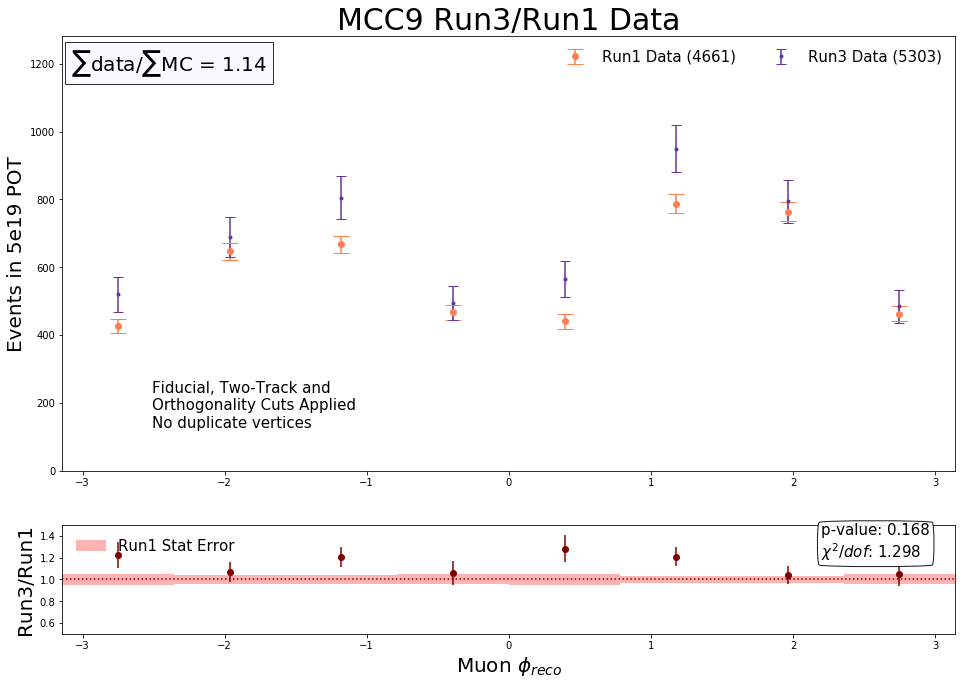

In [69]:
vartest = 'Lepton_PhiReco'
varname = r'Muon $\phi_{reco}$'
myrange = (-np.pi,np.pi)
nbins = 8
yscale = 2e3


fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.1), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.1, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

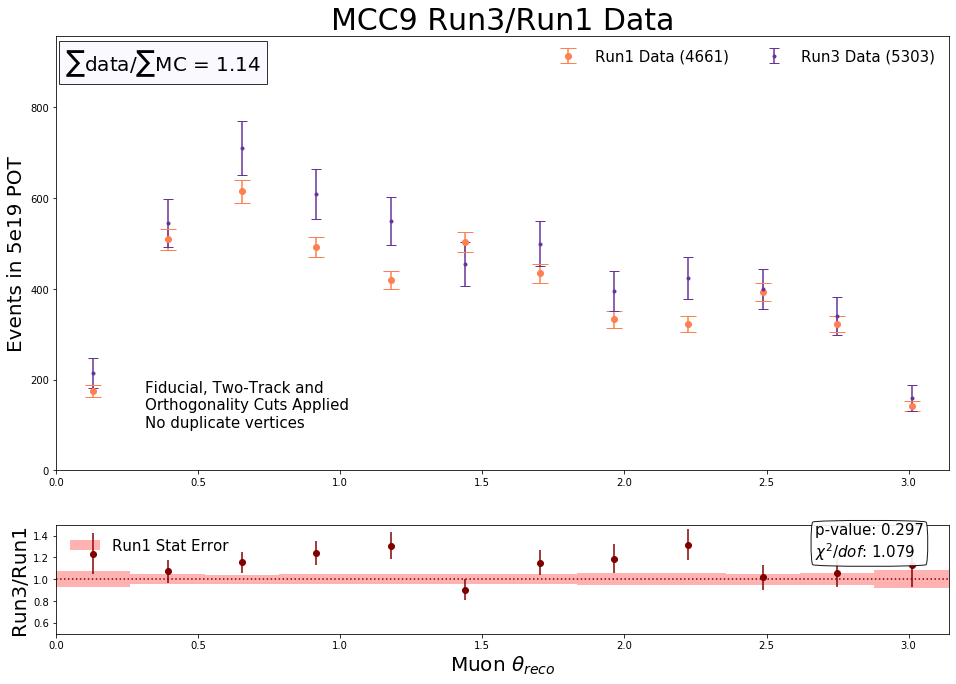

In [70]:
vartest = 'Lepton_ThetaReco'
varname = r'Muon $\theta_{reco}$'
myrange = (0,np.pi)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.1), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

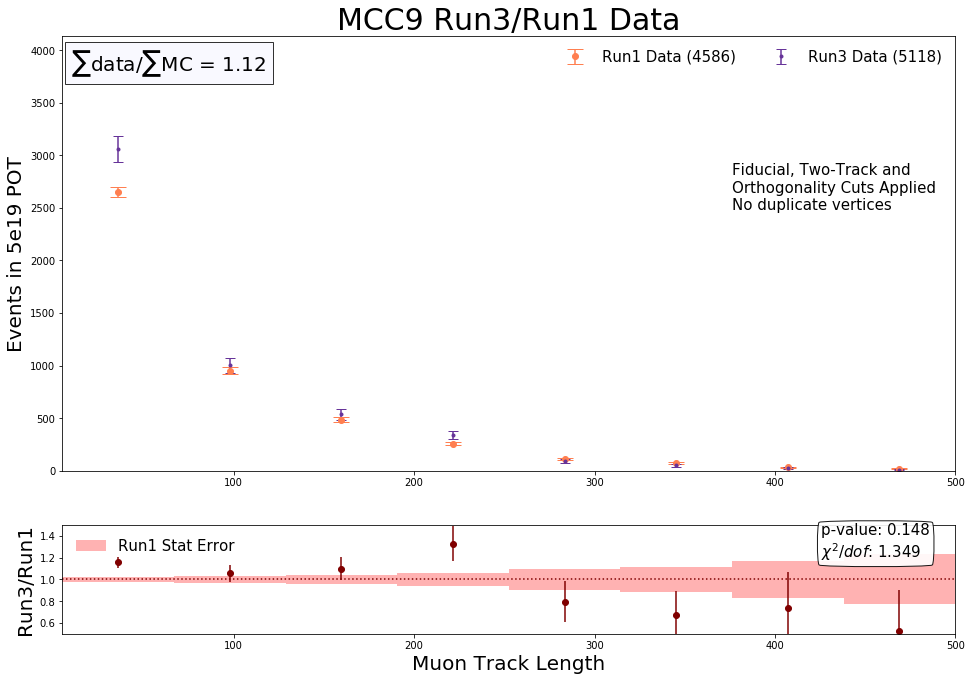

In [71]:
vartest = 'Lepton_TrackLength'
varname = r'Muon Track Length'
myrange = (5,500)
nbins = 8
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

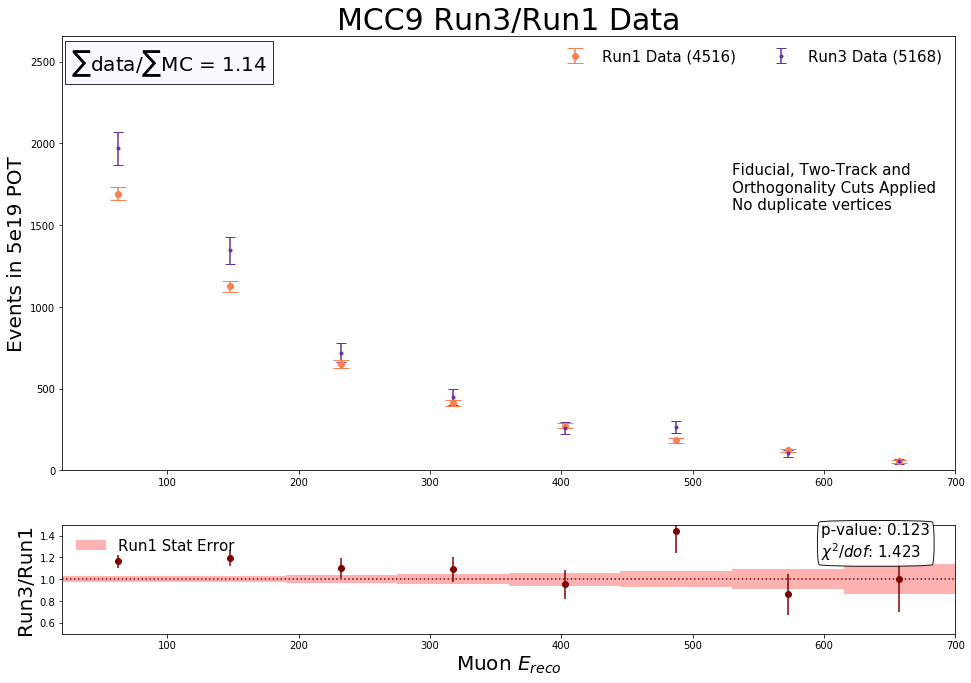

In [72]:
vartest = 'Muon_Edep'
varname = r'Muon $E_{reco}$'
myrange = (20,700)
nbins = 8
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.1, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

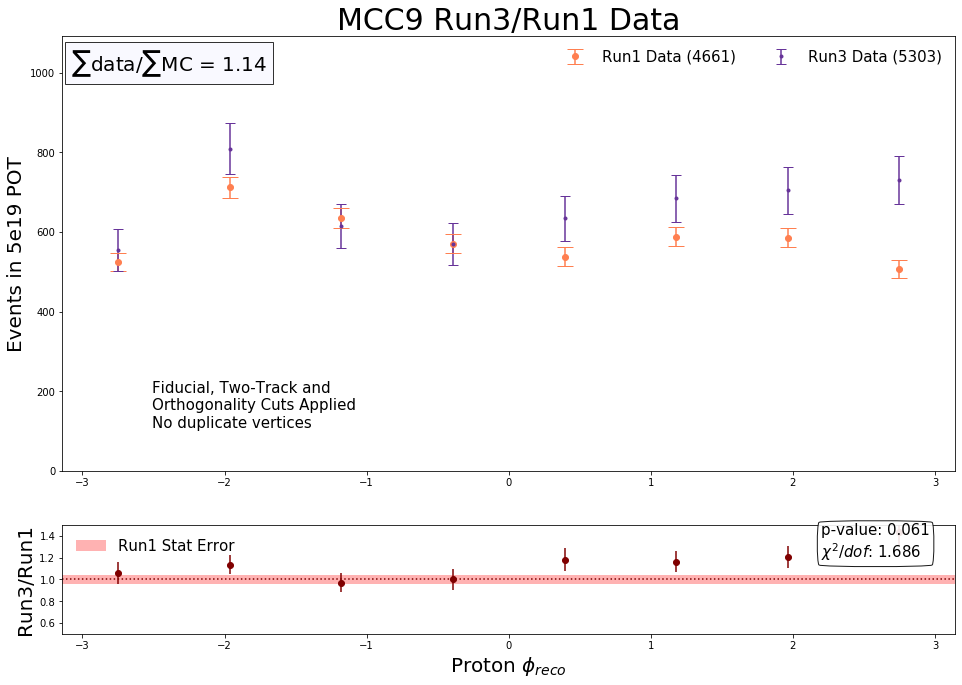

In [73]:
vartest = 'Proton_PhiReco'
varname = r'Proton $\phi_{reco}$'
myrange = (-np.pi,np.pi)
nbins = 8
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.1), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.1, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

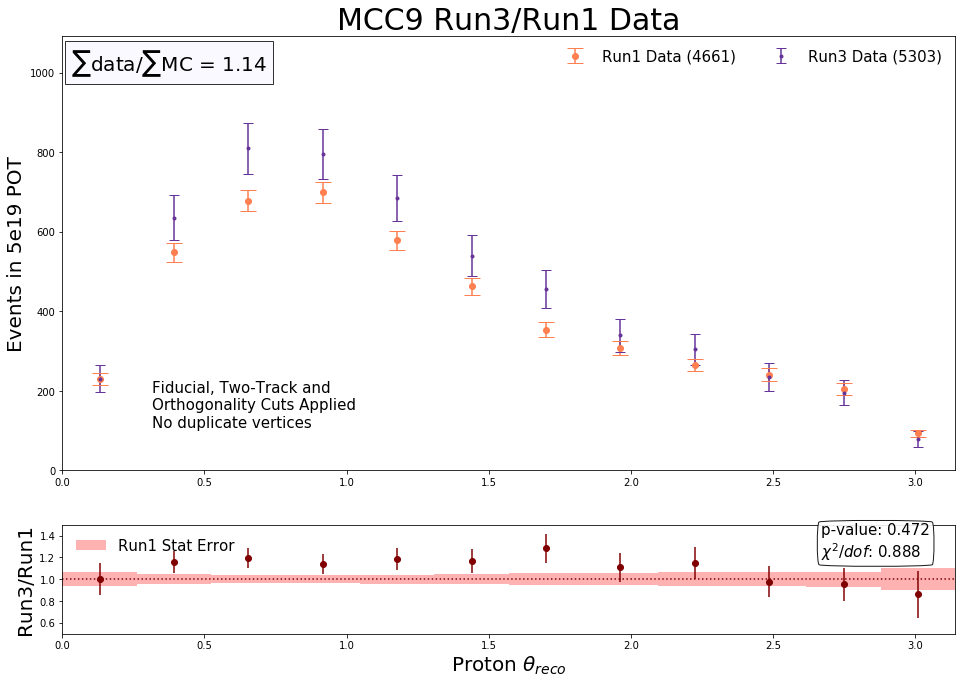

In [74]:
vartest = 'Proton_ThetaReco'
varname = r'Proton $\theta_{reco}$'
myrange = (0,np.pi)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.1), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

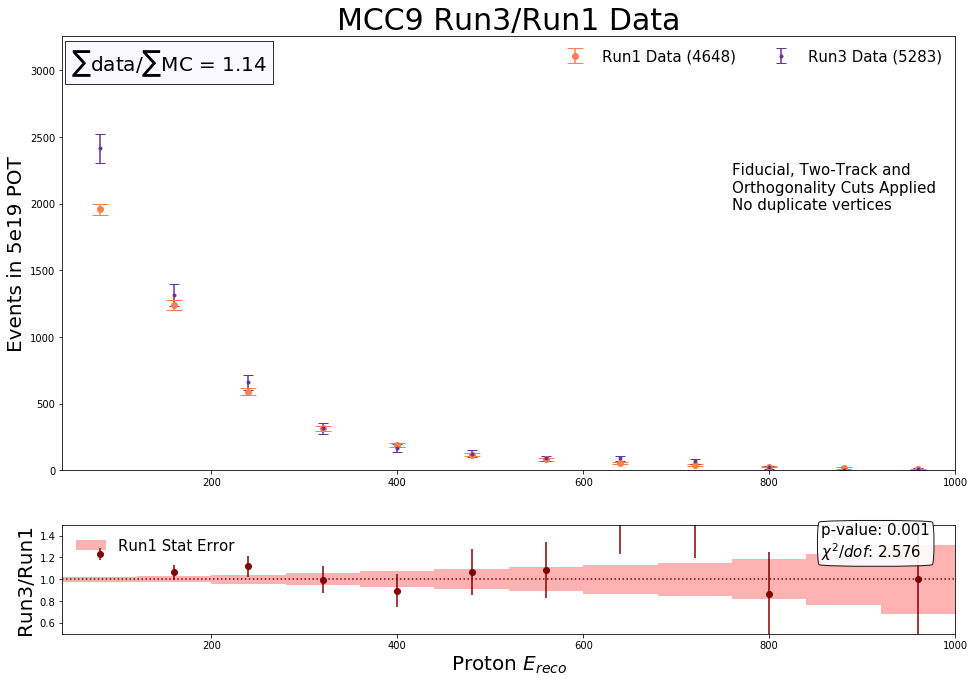

In [75]:
vartest = 'Proton_Edep'
varname = r'Proton $E_{reco}$'
myrange = (40,1000)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.1, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

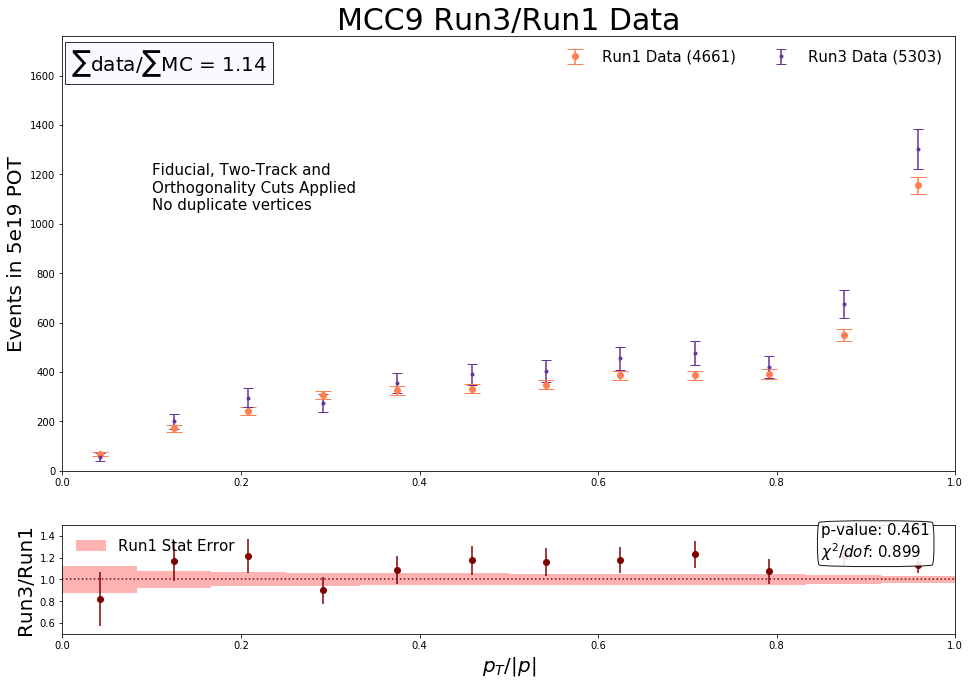

In [58]:
vartest = 'PTRat_1m1p'
varname = r'$p_T/|p|$'
myrange = (0,1)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.1,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

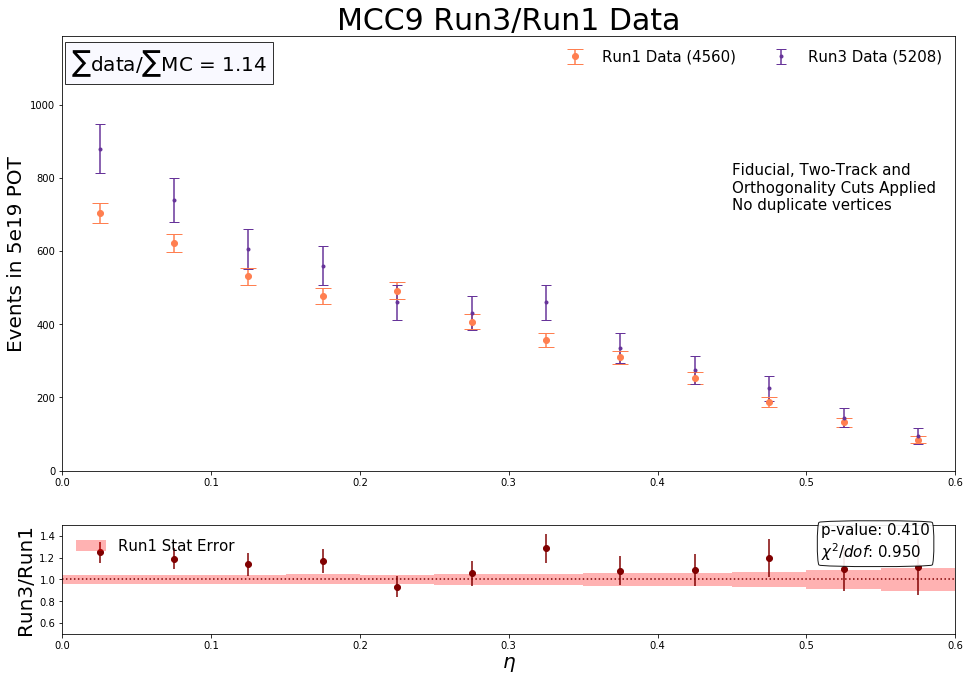

In [76]:
vartest = 'Eta'
varname = r'$\eta$'
myrange = (0,.6)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

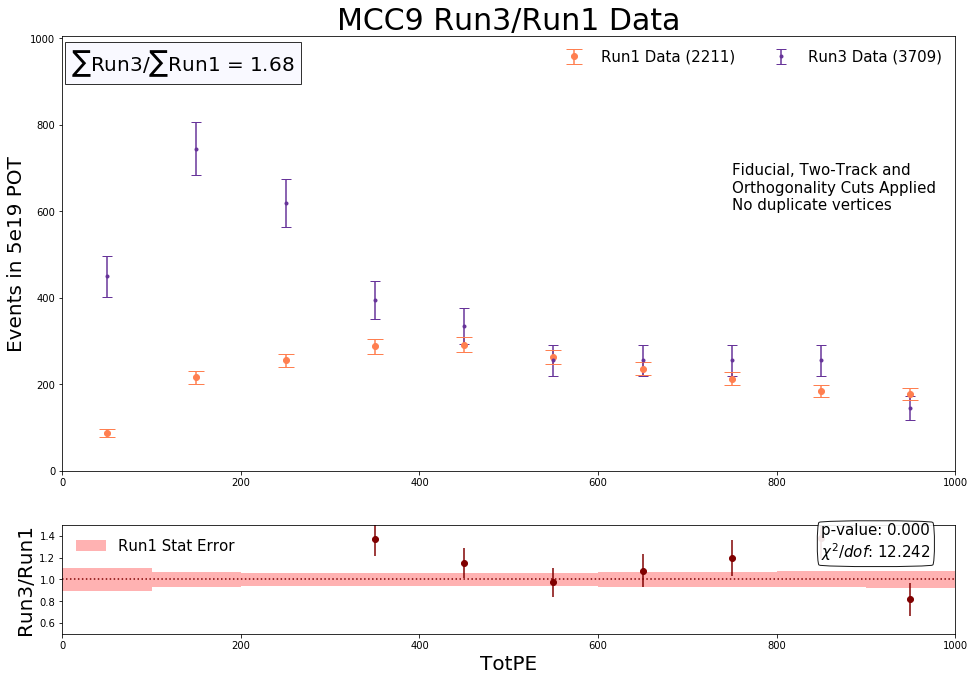

In [88]:
vartest = 'TotPE'
varname = vartest
myrange = (0,1000)
nbins = 10
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Text(0.75, 0.6, 'Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices')

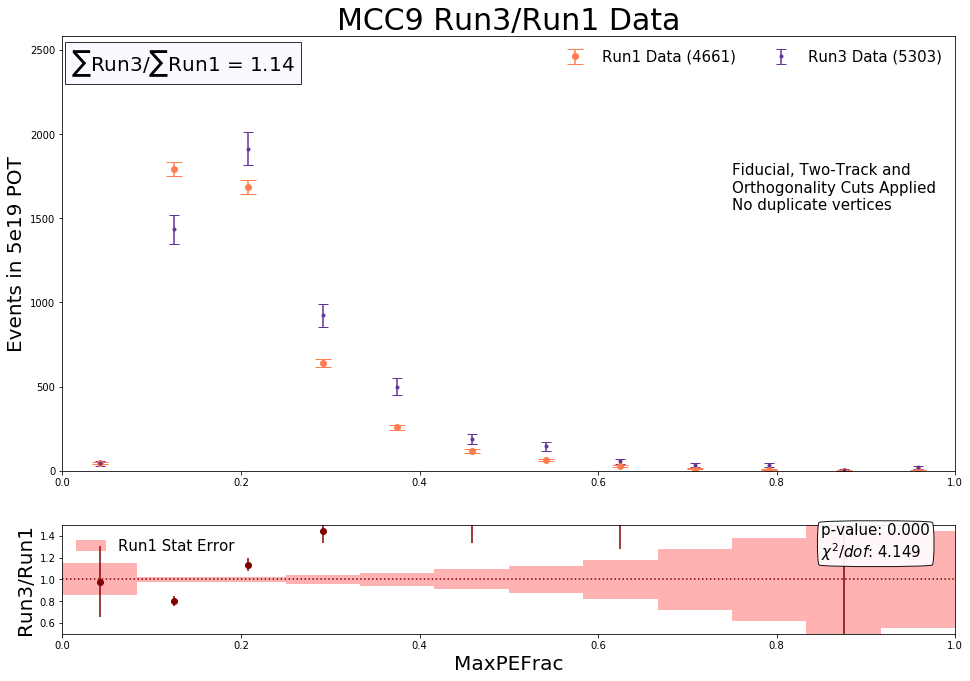

In [84]:
vartest = 'MaxPEFrac'
varname = vartest
myrange = (0,1)
nbins = 12
yscale = 2e3

fig,ax = plt.subplots(figsize=(16,11))
ax0 = distplot_wratio(nbins,myrange,vartest,varname)
ax0.annotate('Fiducial, Two-Track and\nOrthogonality Cuts Applied\nNo duplicate vertices',xy=(.75,.6), xycoords='axes fraction',fontsize=15)

In [78]:
list(df_run1_presel)

['CosBkgScore',
 'run',
 'subrun',
 'event',
 'vtxid',
 'Xreco',
 'Yreco',
 'Zreco',
 'InFiducial',
 'AnyReco',
 'NTracks',
 'N5cmTracks',
 'PassSimpleCuts',
 'PassShowerReco',
 'PassSecondShower',
 'FailedBoost',
 'Good3DReco',
 'Eta',
 'OpenAng',
 'Thetas',
 'Phis',
 'ChargeNearTrunk',
 'LongTrackLen',
 'ShortTrackLen',
 'MaxShrFrac',
 'MinShrFrac',
 'CCQEEnergyShift_1m1p',
 'Enu_1m1p',
 'PhiT_1m1p',
 'AlphaT_1m1p',
 'PT_1m1p',
 'PTRat_1m1p',
 'BjX_1m1p',
 'BjY_1m1p',
 'Q2_1m1p',
 'Sph_1m1p',
 'PzEnu_1m1p',
 'Q0_1m1p',
 'Q3_1m1p',
 'OpenAngB_1m1p',
 'ThetasB_1m1p',
 'PhisB_1m1p',
 'PhiTB_1m1p',
 'AlphaTB_1m1p',
 'PTB_1m1p',
 'BjXB_1m1p',
 'BjYB_1m1p',
 'Q2B_1m1p',
 'SphB_1m1p',
 'Lepton_ID',
 'Lepton_PhiReco',
 'Lepton_ThetaReco',
 'Lepton_TrackLength',
 'Lepton_dQdx_uncalibrated',
 'Lepton_dQdx',
 'Muon_Edep',
 'Lepton_EdgeDist',
 'Muon_PhiRecoB_1m1p',
 'Muon_ThetaRecoB_1m1p',
 'Muon_EdepB_1m1p',
 'Proton_ID',
 'Proton_PhiReco',
 'Proton_ThetaReco',
 'Proton_TrackLength',
 'Proton_d